In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Load Amazon customer review data

# Load 1429_1.csv
df = pd.read_csv("../data/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

In [3]:
df.shape
row=df.shape[0]
cols=df.shape[1]
print('Data dimensions: ', df.shape)
print('Total rows:', row)
print('Total columns: ', cols)
print('Columns: \n', df.columns.values)

Data dimensions:  (28332, 24)
Total rows: 28332
Total columns:  24
Columns: 
 ['id' 'dateAdded' 'dateUpdated' 'name' 'asins' 'brand' 'categories'
 'primaryCategories' 'imageURLs' 'keys' 'manufacturer'
 'manufacturerNumber' 'reviews.date' 'reviews.dateSeen'
 'reviews.didPurchase' 'reviews.doRecommend' 'reviews.id'
 'reviews.numHelpful' 'reviews.rating' 'reviews.sourceURLs' 'reviews.text'
 'reviews.title' 'reviews.username' 'sourceURLs']


In [4]:
# Selecting columns necessary for sentiment analysis

data = df[['reviews.rating', 'reviews.text', 'reviews.title']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews.rating  28332 non-null  int64 
 1   reviews.text    28332 non-null  object
 2   reviews.title   28332 non-null  object
dtypes: int64(1), object(2)
memory usage: 664.2+ KB


In [5]:
### sanity check
print("Null values in dataset: \n", data.isnull().sum())
print("\nNa entries in dataset: \n", data.isna().sum())

Null values in dataset: 
 reviews.rating    0
reviews.text      0
reviews.title     0
dtype: int64

Na entries in dataset: 
 reviews.rating    0
reviews.text      0
reviews.title     0
dtype: int64


Review rating statistics:
2      616
1      965
3     1206
4     5648
5    19897
Name: reviews.rating, dtype: int64


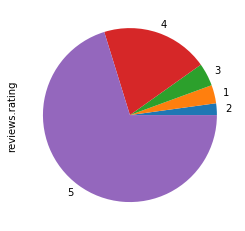

In [6]:
# Count and Visualize distribution of ratings

data = data.dropna(how="any")
review_stats = data['reviews.rating'].value_counts().sort_values()

print("Review rating statistics:")
print(review_stats)

_ = data['reviews.rating'].value_counts().sort_values().plot.pie()

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mirta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mirta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Standard Sentiment Analysis

neg_words = pd.read_csv('../data/negative.csv')
pos_words = pd.read_csv('../data/positive.csv')

print("Positive words : \n", pos_words.head())
print("\nNegative words: \n", neg_words.head())

Positive words : 
        words
0         a+
1     abound
2    abounds
3  abundance
4   abundant

Negative words: 
         words
0     2-faced
1     2-faces
2    abnormal
3     abolish
4  abominable


In [33]:
### helper function to decide sentiment factor in given text
def assign_sentiment(sentence):
    neg_cnt=0
    pos_cnt=0
    neu_cnt=0
    tokenized_sentence=word_tokenize(sentence)
    tokenized_words=[''.join(x for x in y if x not in string.punctuation) for y in tokenized_sentence]
    non_stopwords=[x for x in tokenized_words if x not in stopwords.words("english")]
    for word in non_stopwords:
        if word in neg_words:
            neg_cnt+=1
        elif word in pos_words:
            pos_cnt+=1
        else:
            neu_cnt+=1
    if pos_cnt>neg_cnt:
        return +1
    elif neg_cnt>pos_cnt:
        return -1
    else:
        return 0

In [36]:
pos_reviews=0
neg_reviews=0
neu_reviews=0
for review in data['reviews.text']:
    cnt=assign_sentiment(review)
    if cnt==1:
        pos_reviews+=1
    elif cnt==-1:
        neg_reviews+=1
    else:
        neu_reviews+=1
        

0
23
28309


In [37]:
print("Positive reviews: ", pos_reviews)
print("Negative reviews: ", neg_reviews)
print("Neutral reviews: ", neu_reviews)

Positive reviews:  0
Negative reviews:  23
Neutral reviews:  28309


Sentiment label statistics:
Neutral      1206
Negative     1581
Positive    25545
Name: sentiment_label, dtype: int64


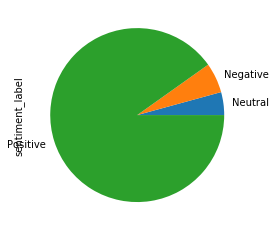

In [41]:
# from above plot we can see that porportion of positive, neutral and negative reviews are quite unusal. To get better result, I intend to use feature engineering to train respective machine learning classifier to predict unlabled review data.

# Assigning sentiment label from review score/ rating

def sentiment_labeler(score):
    if (score==5) or (score==4):
        return "Positive"
    elif (score==3):
        return "Neutral"
    else:
        return "Negative"
    
data["sentiment_label"] = data["reviews.rating"].apply(sentiment_labeler)

sentiment_labels = data['sentiment_label'].value_counts().sort_values()
print("Sentiment label statistics:")
print(sentiment_labels)

_ = data["sentiment_label"].value_counts().sort_values().plot.pie()

In [45]:
### data preparing

from sklearn.model_selection import StratifiedShuffleSplit

split_data=StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for tr_indx, ts_indx in split_data.split(data, data["reviews.rating"]):
    train_data=data.reindex(tr_indx)
    test_data=data.reindex(ts_indx)

print("Train data size: ", train_data.shape)
print("Test data size: ", test_data.shape)

Train data size:  (22665, 4)
Test data size:  (5667, 4)


In [48]:
# Check if distribution of rating is identical after splitting

## sanity check
tr_data_stats= train_data["reviews.rating"].value_counts()/len(train_data)

print("Check for porportion of diff scale rating: \n", tr_data_stats)

ts_data_stats= test_data["reviews.rating"].value_counts()/len(test_data)

print("\nCheck for porportion of diff scale rating in training data: \n", tr_data_stats)

Check for porportion of diff scale rating: 
 5    0.702272
4    0.199338
3    0.042577
1    0.034061
2    0.021752
Name: reviews.rating, dtype: float64

Check for porportion of diff scale rating in training data: 
 5    0.702272
4    0.199338
3    0.042577
1    0.034061
2    0.021752
Name: reviews.rating, dtype: float64


In [50]:
# Preparing data

X_train=train_data['reviews.text']
y_train=train_data["sentiment_label"]
X_test=test_data["reviews.text"]
y_test=test_data["sentiment_label"]
print("Dimension of training data:", X_train.shape)
print("Dimension of testing data:", X_test.shape)

Dimension of training data: (22665,)
Dimension of testing data: (5667,)


In [51]:
## Bag of words

from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_train=X_train.fillna(' ')
X_test=X_test.fillna(' ')
y_train=y_train.fillna(' ')
y_test=y_test.fillna(' ')

X_train_cnts=CountVectorizer().fit_transform(X_train)
print("Dimension of bag of words: \n", X_train_cnts.shape)
print("\n")

Tfidf=TfidfTransformer(use_idf=False)
X_train_tfidf=Tfidf.fit_transform(X_train_cnts)
print("tfidf for X_train", X_train_tfidf)

Dimension of bag of words: 
 (22665, 9642)


tfidf for X_train   (0, 664)	0.30151134457776363
  (0, 5046)	0.30151134457776363
  (0, 5887)	0.30151134457776363
  (0, 6558)	0.30151134457776363
  (0, 6620)	0.30151134457776363
  (0, 6768)	0.30151134457776363
  (0, 6884)	0.30151134457776363
  (0, 8520)	0.6030226891555273
  (1, 628)	0.25
  (1, 664)	0.5
  (1, 769)	0.25
  (1, 3639)	0.25
  (1, 3744)	0.25
  (1, 3952)	0.25
  (1, 4807)	0.25
  (1, 5288)	0.25
  (1, 5922)	0.25
  (1, 6690)	0.25
  (1, 6867)	0.25
  (1, 7445)	0.25
  (1, 9178)	0.25
  (2, 624)	0.2886751345948129
  (2, 664)	0.2886751345948129
  (2, 1738)	0.2886751345948129
  (2, 3568)	0.2886751345948129
  :	:
  (22662, 4683)	0.3922322702763681
  (22662, 4954)	0.19611613513818404
  (22662, 5557)	0.19611613513818404
  (22662, 5810)	0.19611613513818404
  (22662, 7712)	0.19611613513818404
  (22662, 8192)	0.19611613513818404
  (22662, 8510)	0.19611613513818404
  (22662, 8642)	0.19611613513818404
  (22662, 8664)	0.19611613513818404
  (22662, 9590)

In [52]:
### build machine learning models from extracted bag of words features

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [54]:
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train,y_train)
predicted_nb = clf_multiNB_pipe.predict(X_test)
print("Naive Bayes classifier accuracy report:\n",metrics.classification_report(y_test, predicted_nb, target_names = ['1','0','-1']))

Naive Bayes classifier accuracy report:
               precision    recall  f1-score   support

           1       0.80      0.03      0.05       316
           0       0.00      0.00      0.00       241
          -1       0.90      1.00      0.95      5110

    accuracy                           0.90      5667
   macro avg       0.57      0.34      0.33      5667
weighted avg       0.86      0.90      0.86      5667



In [55]:
LR = LogisticRegression()
# text_pipe_LR = Pipeline([('tfidf', TfidfVectorizer()), ('LR', LR)])
clf_logitReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logitReg", LogisticRegression())])
clf_logitReg_pipe.fit(X_train,y_train)
predicted_lr = clf_logitReg_pipe.predict(X_test)
print("Linear Regression accuracy report:\n",metrics.classification_report(y_test, predicted_lr, target_names = ['1','0','-1']))

Linear Regression accuracy report:
               precision    recall  f1-score   support

           1       0.76      0.54      0.63       316
           0       0.61      0.11      0.19       241
          -1       0.94      0.99      0.97      5110

    accuracy                           0.93      5667
   macro avg       0.77      0.55      0.60      5667
weighted avg       0.92      0.93      0.91      5667



In [56]:
sgd_clf = linear_model.SGDClassifier(max_iter=1000)
clf_sgd_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_SGD", sgd_clf)])
clf_sgd_pipe.fit(X_train,y_train)
predicted_sgd = clf_sgd_pipe.predict(X_test)
print("SGD classifier accuracy report:\n",metrics.classification_report(y_test, predicted_sgd, target_names = ['1','0','-1']))

SGD classifier accuracy report:
               precision    recall  f1-score   support

           1       0.81      0.55      0.65       316
           0       0.00      0.00      0.00       241
          -1       0.94      1.00      0.97      5110

    accuracy                           0.93      5667
   macro avg       0.58      0.52      0.54      5667
weighted avg       0.89      0.93      0.91      5667



C:\Users\mirta\Anaconda3\envs\Py_T\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
clf_svc_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_svc", LinearSVC())])
clf_svc_pipe.fit(X_train,y_train)
predicted_svc = clf_svc_pipe.predict(X_test)
print("SVC classifier accuracy report:\n",metrics.classification_report(y_test, predicted_svc, target_names = ['1','0','-1']))

SVC classifier accuracy report:
               precision    recall  f1-score   support

           1       0.79      0.73      0.76       316
           0       0.72      0.30      0.43       241
          -1       0.96      0.99      0.98      5110

    accuracy                           0.95      5667
   macro avg       0.82      0.67      0.72      5667
weighted avg       0.94      0.95      0.94      5667



In [58]:
clf_dt_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_dt", DecisionTreeClassifier())])
clf_dt_pipe.fit(X_train,y_train)
predicted_dt = clf_dt_pipe.predict(X_test)
print("Decision tree classifier accuracy report:\n",metrics.classification_report(y_test, predicted_dt, target_names = ['1','0','-1']))

Decision tree classifier accuracy report:
               precision    recall  f1-score   support

           1       0.69      0.66      0.67       316
           0       0.64      0.49      0.55       241
          -1       0.96      0.98      0.97      5110

    accuracy                           0.94      5667
   macro avg       0.76      0.71      0.73      5667
weighted avg       0.93      0.94      0.94      5667



In [59]:
clf_randforest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randforest", RandomForestClassifier())])
clf_randforest_pipe.fit(X_train,y_train)
predicted_randforest = clf_randforest_pipe.predict(X_test)
print("Random forest classifier accuracy report:\n",metrics.classification_report(y_test, predicted_randforest, target_names = ['1','0','-1']))

Random forest classifier accuracy report:
               precision    recall  f1-score   support

           1       0.94      0.53      0.68       316
           0       0.97      0.43      0.60       241
          -1       0.95      1.00      0.97      5110

    accuracy                           0.95      5667
   macro avg       0.95      0.65      0.75      5667
weighted avg       0.95      0.95      0.94      5667

